In [1]:
import pandas as pd
from dython.nominal import associations
from sklearn.cluster import DBSCAN

from gower.gower_dist import *

# Simple example from D'Orazio

In [2]:
df = pd.DataFrame({"Sex1": ["M", "M", "F", "F", "F", "M", "M", "F", "F", "F"],
                   "Sex2": ["M", "M", "F", "F", "F", "F", "F", "M", "M", "M"],
                   "Age1": [15] * 10,
                   "Age2": [15, 36, 58, 78, 100, 15, 36, 58, 78, 100]})

In [3]:
distances = np.diag(gower_matrix(df[["Sex1", "Age1"]].to_numpy(), df[["Sex2", "Age2"]].to_numpy(),
                                 weight_cat="uniform", weight_num="uniform"))
print(distances)
df.loc[np.argsort(distances)]

[1.] [1.]


  0%|          | 0/10 [00:00<?, ?it/s]

[0.         0.12352941 0.25294118 0.37058824 0.5        0.5
 0.62352941 0.75294118 0.87058824 1.        ]


,Sex1,Sex2,Age1,Age2
0,M,M,15,15
1,M,M,15,36
2,F,F,15,58
3,F,F,15,78
4,F,F,15,100
5,M,F,15,15
6,M,F,15,36
7,F,M,15,58
8,F,M,15,78
9,F,M,15,100


# Metrics

### We can also use the categorical weight function to measure cluster quality and thereby tune clustering algorithms such as DBSCAN.

##### I calculated Gower distances for each of the four datasets above using the new weighting scheme, and then ran a grid search with DBSCAN based on the new weighting formula for categorical variables.

# Istanbul dataset

[1. 1. 1. 1.] [1. 1. 1. 1.]


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

({'eps': 0.12, 'min_samples': 1}, 0.962752781265015)
(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  45,  46,  47,  48,  49,  50,  51,  52,  53,  55,
        57,  59,  60,  61,  62,  63,  64,  65,  67,  69,  70,  71,  72,
        75,  83,  84,  87,  90,  91,  92,  94, 100, 103, 134, 137, 138,
       154, 189, 203]), array([47, 28, 24, 19, 23, 20, 18, 27, 19, 16, 15, 10, 17, 10, 20, 11, 14,
        9, 10,  6,  8,  9,  4, 12,  7,  5,  3,  2,  2,  6,  6,  4,  5,  3,
        2,  4,  2,  2,  2,  3,  3,  5,  1,  4,  4,  2,  2,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  3,  1,  1,  2,  1,  1,  1,  1,  2,  1,  1,
        1,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1]))


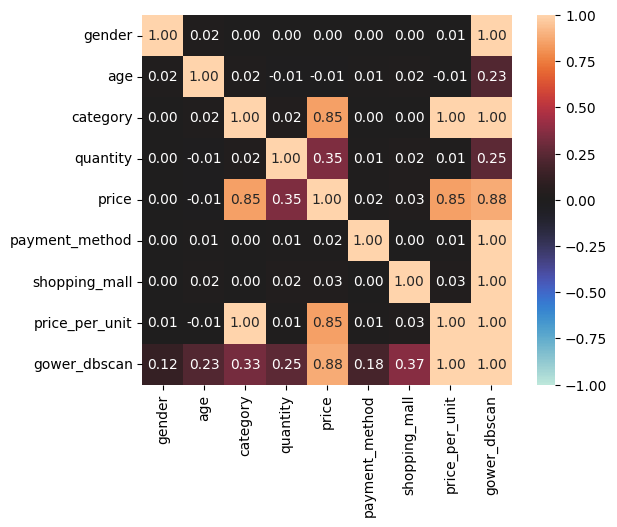

,gender,age,category,quantity,price,payment_method,shopping_mall,price_per_unit,gower_dbscan,label_count
65992,Female,53,Clothing,3,900.24,Cash,Kanyon,300.08,38,203
1514,Female,34,Clothing,1,300.08,Cash,Kanyon,300.08,38,203
87290,Female,63,Clothing,1,300.08,Cash,Kanyon,300.08,38,203
23436,Female,33,Clothing,4,1200.32,Cash,Kanyon,300.08,38,203
46834,Female,22,Clothing,3,900.24,Cash,Kanyon,300.08,38,203
...,...,...,...,...,...,...,...,...,...,...
7314,Male,24,Shoes,4,2400.68,Debit Card,Emaar Square Mall,600.17,511,1
75393,Female,38,Technology,3,3150.00,Debit Card,Zorlu Center,1050.00,512,1
12166,Female,63,Technology,1,1050.00,Debit Card,Forum Istanbul,1050.00,513,1
31139,Male,34,Souvenir,5,58.65,Credit Card,Emaar Square Mall,11.73,514,1


In [4]:
istanbul = pd.read_csv("customer_shopping_data.csv").sample(n=10000, random_state=0).iloc[:, 2:]  # no nulls!
istanbul["price_per_unit"] = istanbul["price"] / istanbul["quantity"]
istanbul.drop("invoice_date", axis=1, inplace=True)

matrix4 = gower_matrix(istanbul.to_numpy(), weight_cat="uniform", weight_num="uniform", chunksize=20)

samples = [{"eps": z / 100, "min_samples": 1} for z in range(1, 101)]

results4 = process_map(partial(evaluate_clusters, matrix=matrix4), samples, chunksize=1)

best_params4 = max(results4, key=lambda z: z[1])

print(best_params4)

istanbul["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params4[0]).fit_predict(matrix4)
istanbul.gower_dbscan = istanbul.gower_dbscan.astype(str)

_, counts4 = np.unique(istanbul["gower_dbscan"], return_counts=True)

print(np.unique(counts4, return_counts=True))

associations(istanbul, nom_nom_assoc="theil", plot=True)

istanbul["label_count"] = istanbul.groupby("gower_dbscan").transform("count").iloc[:, 0]

istanbul.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

istanbul


# Laptops dataset

(977, 12)
Model Name                  488
Category                      6
Screen Size                  18
Screen                       38
CPU                         106
RAM                           8
 Storage                     36
GPU                          98
Operating System              7
Operating System Version      5
Weight                      166
Price                       639
dtype: int64
[1. 1. 1. 1. 1. 1. 1. 1. 1.] [1.]


  0%|          | 0/977 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

({'eps': 0.2, 'min_samples': 1}, 0.6358640938212206)
(array([ 1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 26, 43, 45]), array([496,  69,  18,   6,   7,   6,   4,   2,   1,   1,   1,   1,   1,
         1]))


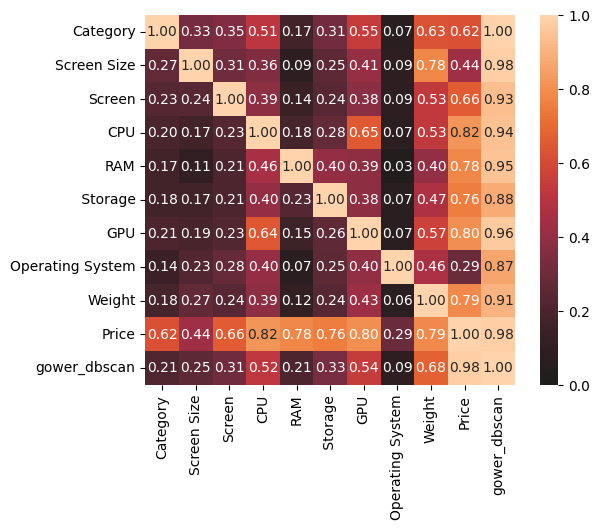

,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Weight,Price,gower_dbscan,label_count
Manufacturer,,,,,,,,,,,,
HP,Notebook,"15.6""",Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,500GB HDD,Intel HD Graphics 520,No OS,1.86kg,3067651.08,10,45
Dell,Notebook,"15.6""",Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,256GB SSD,AMD Radeon R5 M430,Windows,2.2kg,4436218.80,10,45
Dell,Notebook,"15.6""",1366x768,Intel Core i3 6006U 2GHz,4GB,1TB HDD,Intel HD Graphics 520,Windows,2.3kg,3722546.88,10,45
HP,Notebook,"15.6""",Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows,1.91kg,3903588.00,10,45
HP,Notebook,"15.6""",1366x768,Intel Core i3 6006U 2GHz,4GB,500GB HDD,AMD Radeon 520,Windows,1.86kg,3900831.48,10,45
...,...,...,...,...,...,...,...,...,...,...,...,...
Asus,Notebook,"17.3""",Full HD 1920x1080,Intel Core i3 6006U 2GHz,4GB,1TB HDD,Nvidia GeForce 920MX,Windows,2kg,5015088.00,94,1
Asus,Notebook,"15.6""",Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,256GB SSD,Nvidia GeForce 940MX,Windows,1.7kg,9941256.00,95,1
Acer,Notebook,"15.6""",IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i3 7100U 2.4GHz,6GB,1TB HDD,Intel HD Graphics 620,Windows,2.1kg,4259268.00,96,1


In [5]:
laptops = pd.read_csv("laptops/laptops_train.csv", index_col=0)
print(laptops.shape)
print(laptops.apply(lambda col: col.unique(), axis=0).apply(len))
laptops.drop(["Operating System Version", "Model Name"], axis=1, inplace=True)

matrix3 = gower_matrix(laptops.to_numpy(), weight_cat="uniform", weight_num="uniform", chunksize=20)
samples = [{"eps": z / 1000, "min_samples": 1} for z in range(1, 1001)]
results3 = process_map(partial(evaluate_clusters, matrix=matrix3), samples, chunksize=20)
best_params3 = max(results3, key=lambda z: z[1])
print(best_params3)
laptops["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params3[0]).fit_predict(matrix3)
laptops.gower_dbscan = laptops.gower_dbscan.astype(str)
_, counts3 = np.unique(laptops["gower_dbscan"], return_counts=True)
print(np.unique(counts3, return_counts=True))

associations(laptops, nom_nom_assoc="theil", plot=True)

laptops["label_count"] = laptops.groupby("gower_dbscan").transform("count").iloc[:, 0]
laptops.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

laptops


# Pokemon dataset

[1. 1. 1. 1. 1. 1. 1. 1. 1.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

({'eps': 0.12, 'min_samples': 1}, 0.686815810242495)
(array([  1,   2,   3,   4,   6,   7,   9,  10,  13,  14,  18,  33, 149]), array([220,  64,  22,   8,   1,   2,   2,   1,   1,   1,   1,   1,   1]))


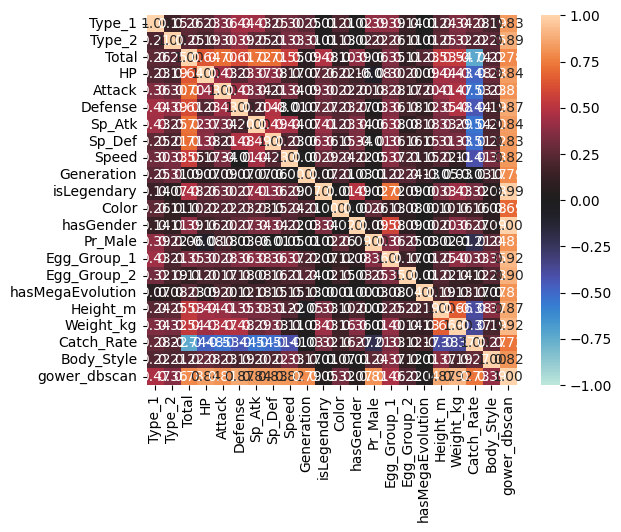

,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,...,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style,gower_dbscan,label_count
18,Normal,none,253,30,56,35,25,35,72,1,...,0.50,Field,none,False,0.30,3.5,255,quadruped,8,149
19,Normal,none,413,55,81,60,50,70,97,1,...,0.50,Field,none,False,0.71,18.5,127,quadruped,8,149
36,Fire,none,299,38,41,40,50,65,65,1,...,0.25,Field,none,False,0.61,9.9,190,quadruped,8,149
37,Fire,none,505,73,76,75,81,100,100,1,...,0.25,Field,none,False,1.09,19.9,75,quadruped,8,149
51,Normal,none,290,40,45,35,40,40,90,1,...,0.50,Field,none,False,0.41,4.2,255,quadruped,8,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Bug,Steel,500,70,130,100,55,80,65,2,...,0.50,Bug,none,True,1.80,118.0,25,four_wings,93,1
212,Bug,Rock,505,20,10,230,10,230,5,2,...,0.50,Bug,none,False,0.61,20.5,190,insectoid,94,1
213,Bug,Fighting,500,80,125,75,40,95,85,2,...,0.50,Bug,none,True,1.50,54.0,45,bipedal_tailless,95,1
217,Fire,none,250,40,40,40,70,40,20,2,...,0.50,Amorphous,none,False,0.71,35.0,190,serpentine_body,97,1


In [6]:
pokemon = pd.read_csv("pokemon/pokemon_alopez247.csv").iloc[:, 2:]
for c in pokemon.columns[pokemon.dtypes != object]:
    pokemon.loc[pokemon[c].isna(), c] = np.nanmedian(pokemon[c])
for c in pokemon.columns[pokemon.dtypes == object]:
    pokemon.loc[pokemon[c].isna(), c] = "none"

matrix2 = gower_matrix(pokemon.to_numpy(), weight_cat="uniform", weight_num="uniform", chunksize=20)
samples = [{"eps": z / 100, "min_samples": 1} for z in range(1, 1001)]
results2 = process_map(partial(evaluate_clusters, matrix=matrix2), samples, chunksize=20)
best_params2 = max(results2, key=lambda z: z[1])
print(best_params2)
pokemon["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params2[0]).fit_predict(matrix2)
pokemon.gower_dbscan = pokemon.gower_dbscan.astype(str)
_, counts2 = np.unique(pokemon["gower_dbscan"], return_counts=True)
print(np.unique(counts2, return_counts=True))

associations(pokemon, nom_nom_assoc="theil", plot=True)

pokemon["label_count"] = pokemon.groupby("gower_dbscan").transform("count").iloc[:, 0]
pokemon.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

pokemon


# Dog adoption dataset

breed_secondary
color_primary
color_secondary
color_tertiary
declawed
env_cats
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.] []


  0%|          | 0/13729 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

({'eps': 0.25, 'min_samples': 1}, 0.8026822912028754)
(array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   27,   28,   29,   30,   31,   36,   37,   40,
         41,   44,   45,   48,   55,   56,   57,   59,   60,   61,   66,
         68,   74,   79,   84,   85,   87,   93,  109,  110,  114,  118,
        139,  148,  171,  176,  191,  221,  226,  267,  276,  289,  335,
        346,  489, 2154]), array([2156,  359,  153,   86,   59,   39,   33,   19,   24,   17,   10,
          8,   11,    5,    5,    4,    5,    3,    4,    6,    2,    5,
          5,    1,    2,    1,    1,    2,    1,    1,    1,    1,    1,
          1,    1,    4,    1,    1,    1,    2,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1]))


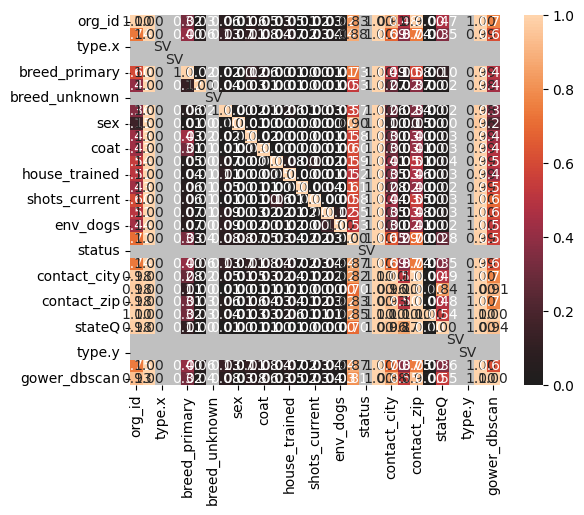

,org_id,url,type.x,species,breed_primary,breed_mixed,breed_unknown,age,sex,size,...,contact_city,contact_state,contact_zip,contact_country,stateQ,accessed,type.y,description,gower_dbscan,label_count
id,,,,,,,,,,,,,,,,,,,,,
46034246,AL268,https://www.petfinder.com/dog/daisy-46034246/a...,Dog,Dog,Labrador Retriever,True,False,Baby,Female,Medium,...,Alabaster,AL,35007,US,AL,2019-09-20,Dog,"Daisy is a 3 1/2 month old lab, possible husky...",123,2154
46015599,AL268,https://www.petfinder.com/dog/brutus-46015599/...,Dog,Dog,Labrador Retriever,True,False,Young,Male,Medium,...,Alabaster,AL,35007,US,AL,2019-09-20,Dog,"Brutus is around a year old. He's sweet, lovin...",123,2154
45844655,AL254,https://www.petfinder.com/dog/aiden-45844655/a...,Dog,Dog,Basset Hound,True,False,Adult,Male,Medium,...,Alabaster,AL,35007,US,AL,2019-09-20,Dog,Aiden wants you to know he is still available!...,123,2154
45844607,AL254,https://www.petfinder.com/dog/patches-45844607...,Dog,Dog,Great Pyrenees,True,False,Young,Male,Large,...,Alabaster,AL,35007,US,AL,2019-09-20,Dog,Patches! This handsome boy is an adorable pyr-...,123,2154
45837822,AL268,https://www.petfinder.com/dog/ruby-45837822/al...,Dog,Dog,Labrador Retriever,True,False,Baby,Female,Medium,...,Alabaster,AL,35007,US,AL,2019-09-20,Dog,12 week old Female Lab mix - \n\nRUBY is ready...,123,2154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23731398,WV27,https://www.petfinder.com/dog/daphne-23731398/...,Dog,Dog,Border Collie,True,False,Adult,Female,Medium,...,Charles Town,WV,25414,US,DC,2019-09-20,Dog,Daphne is one of our âSpecial Needsâ dogs....,995,1
21274228,MD368,https://www.petfinder.com/dog/minnie-21274228/...,Dog,Dog,Pit Bull Terrier,True,False,Senior,Female,Medium,...,Silver Spring,MD,20905,US,DC,2019-09-20,Dog,MINNIE NEEDS A LOVING FOREVER HOME!!!\nFosters...,996,1
46038666,NJ904,https://www.petfinder.com/dog/ella-46038666/nj...,Dog,Dog,Golden Retriever,True,False,Young,Female,Medium,...,Cherry Hill,NJ,08034,US,DE,2019-09-20,Dog,Say hi to Ella! This Southern Belle will be ar...,997,1


In [7]:
dd = pd.read_csv("dog_adoption/allDogDescriptions.csv", index_col=0)
dd.set_index("id", inplace=True, drop=True)


# get rid of columns with the most destructive nans

def isolate_nans(column):
    all_other_nans = nans[[c for c in cols if c != column]].sum(axis=1)
    mask = all_other_nans < np.median(all_other_nans)
    mask &= nans[column]
    return mask.sum()


nans = dd.isna()
cols = dd.columns
isolated_nans = {c: isolate_nans(c) for c in cols}
median_count = np.median([v for v in isolated_nans.values() if v > 0])
for column, count in isolated_nans.items():
    if count > median_count:
        print(column)
        dd.drop(column, axis=1, inplace=True)
dd.dropna(inplace=True)  # dd.mode().iloc[0]

# make bools strings
is_bool = dd.dtypes == bool
dd.loc[:, is_bool] = dd[dd.columns[is_bool]].astype(str)

matrix = gower_matrix(dd.to_numpy(), weight_cat="uniform", weight_num="uniform", chunksize=20)
samples = [{"eps": z / 100, "min_samples": 1} for z in range(1, 101)]
results = process_map(partial(evaluate_clusters, matrix=matrix), samples, chunksize=1)
best_params = max(results, key=lambda z: z[1])
print(best_params)
dd["gower_dbscan"] = DBSCAN(metric="precomputed", **best_params[0]).fit_predict(matrix)
dd.gower_dbscan = dd.gower_dbscan.astype(str)
_, counts = np.unique(dd["gower_dbscan"], return_counts=True)
print(np.unique(counts, return_counts=True))

associations(dd, nom_nom_assoc="theil", plot=True)

dd["label_count"] = dd.groupby("gower_dbscan").transform("count").iloc[:, 0]
dd.sort_values(["label_count", "gower_dbscan"], ascending=[False, True], inplace=True)

dd
